In [1]:
from abc import ABC, abstractmethod
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from binance.client import Client
import time

In [2]:
data_config = {
  'data_dir': '../data/BTCUSDT',
  'names': ["open time", "open", "high", "low", "close", "volume",
            "close time", "quote asset volume", "number of trades",
            "taker buy base asset volume", "taker buy quote asset volume", "date"],
  'columns': ["open time", "open", "high", "low", "close", "volume"], 
  'start_date': '2017-08', 
  'end_date': '2022-03', 
  'ticker': 'BTCUSDT',
  'interval': '1h', 
}

trader_config = {
    # out of sample start date
    'oos_start_date': '2021-07-01', 
    # np.log(1 - commision) + np.log(1 - slippage)
    # np.log(1 - 0.00075) + np.log(1 - 0.0001)
    'commissions': -0.00085,
}

In [23]:
class DataLoader():
    def __init__(self, config):
        self.config = config
        self.data = self.load_data()
        
    def load_data(self):
        """
            Load data and return prepared data frame
        """
        df = pd.DataFrame()
        for d in tqdm(pd.date_range(self.config['start_date'], self.config['end_date'], freq='M')):
            temp_dir = os.path.join(self.config['data_dir'], self.config['interval'],
                                    '{}-{}-{}-{:02}.zip'.format(self.config['ticker'],
                                                         self.config['interval'], 
                                                         d.year, 
                                                         d.month))
            df = df.append(pd.read_csv(temp_dir, names=self.config['names']))
        
        df = df[self.config['columns']]
        df['date'] = pd.to_datetime(df['open time'], unit='ms')
        df["log_return"] = np.log(df['close'] / df['close'].shift(1))
        df = df.drop('open time', axis=1)
        return df

In [24]:
class SpotBacktester(ABC):
    def __init__(self, config, data):
        self.config = config
        self.full_data = data
        
    def get_oos_data(self):
        """
            Returns out-of-sample data
        """
        return self.full_data[self.full_data['date'] >= pd.to_datetime(self.config['oos_start_date'])]
    
    def get_is_data(self):
        """
            Returns in-sample data
        """
        return self.full_data[self.full_data['date'] < pd.to_datetime(self.config['oos_start_date'])]
    
    @staticmethod
    def calculate_metics(df):
        """
            Returns dictionary with metrics
        """
        res_dict = {}
        res_dict['cum_real_ret'] = df['creturn'].to_list()[-1]
        res_dict['cum_str_ret'] = df['cstrategy'].to_list()[-1]
        
        return res_dict
    
    @staticmethod
    def plot_str(df):
        """
            Plots cumulative return of strategy and real cumulative return
        """
        plt.rcParams["figure.figsize"] = (11, 7)
        df[['cstrategy', 'creturn']] = df[['cstrategy', 'creturn']]*100
        df[['date', 'cstrategy', 'creturn']].set_index('date').plot()
        plt.grid()
        plt.ylabel('Cumulative return in percentage')
    
    @staticmethod
    @abstractmethod
    def optimize():
        """
            Abstract class for strategy optimizing
        """
        pass

In [62]:
class GoldenCrossStrategy(SpotBacktester):
    def __init__(self, config, data):
        super().__init__(config, data)
        self.is_data = self.get_is_data()
        self.oos_data = self.get_oos_data()
    
    def apply_strategy(self, ma_high, ma_low, plot=False, oos=False):
        """
            The main logic of the strategy
        """
        if oos:
            df = self.oos_data.copy()
        else:
            df = self.is_data.copy()

        df[f'ma_{ma_high}'] = df['close'].rolling(ma_high).mean()
        df[f'ma_{ma_low}'] = df['close'].rolling(ma_low).mean()
        
        # slower way to calcuate position
        # df['position'] = df[[f'ma_{ma_low}', f'ma_{ma_high}']].apply(lambda x: 1 if x[0] >= x[1] else 0, axis=1)
        df['position'] = np.sign(np.sign(df[f'ma_{ma_low}'] - df[f'ma_{ma_high}']) + 1).fillna(0)

        df['str_return'] = df['position'].shift(1) * df['log_return']
        df['trades'] = df['position'].diff().fillna(0).abs()
        df['str_return'] = df['str_return'] + df['trades']*self.config['commissions']
        
        df['creturn'] = df['log_return'].cumsum().apply(np.exp) - 1
        df['cstrategy'] = df['str_return'].cumsum().apply(np.exp) - 1

        metrics_dict = self.calculate_metics(df)
        
        if plot:
            print('Strategy return: {}'.format(metrics_dict['cum_str_ret']))
            print('Real return: {}'.format(metrics_dict['cum_real_ret']))
            self.plot_str(df)
        
        return metrics_dict
    
    def optimize(self, heatmap=True, oos=False):
        """
            Optimizes strategy parameters
        """
        res_dict = {'ma_high': [], 'ma_low': [], 'str_return': [], 'real_return': []}
        for ma_high in tqdm(range(50, 501, 10)):
            for ma_low in range(5, 201, 5):
                temp_metrics = self.apply_strategy(ma_high, ma_low, oos=oos)
                res_dict['ma_high'].append(ma_high)
                res_dict['ma_low'].append(ma_low)
                res_dict['str_return'].append(temp_metrics['cum_str_ret'])
                res_dict['real_return'].append(temp_metrics['cum_real_ret'])
        
        df_res = pd.DataFrame(res_dict).sort_values(by='str_return', ascending=False)
        df_res[['str_return', 'real_return']] = df_res[['str_return', 'real_return']]*100
        
        print('Best result')
        print(df_res[:1])
        
        if heatmap:
            plt.rcParams["figure.figsize"] = (14,14*200/500)
            pv = df_res.pivot('ma_high', 'ma_low', 'str_return')
            Y, X = np.meshgrid(pv.columns.values, pv.index.values)
            plt.contourf(X, Y, pv.values, 20, cmap=cm.jet)
            
            if not oos:
                plt.title("""Cumulative return heatmap in respect to high and low moving average
                where real return is: {:.6}""".format(df_res['real_return'].to_list()[0]))
            else:
                plt.title("""OOS Cumulative return heatmap in respect to high and low moving average
                where real return is: {:.6}""".format(df_res['real_return'].to_list()[0]))
                
            plt.xlabel('MA high')
            plt.ylabel('MA low')
            plt.colorbar()
            plt.show()
        
        return df_res

In [33]:
dl = DataLoader(data_config)
df = dl.data
df.tail()

  0%|          | 0/55 [00:00<?, ?it/s]

,open,high,low,close,volume,date,log_return
667,41204.65,41392.00,41009.28,41329.44,1927.69571,2022-02-28 19:00:00,0.003024
668,41329.44,41950.00,41248.41,41908.07,3794.77339,2022-02-28 20:00:00,0.013903
669,41908.08,41918.02,41500.56,41644.99,1373.72185,2022-02-28 21:00:00,-0.006297
670,41645.00,44225.84,41628.99,43026.44,8825.95745,2022-02-28 22:00:00,0.032634
671,43026.45,43346.92,42847.00,43160.00,4081.96888,2022-02-28 23:00:00,0.003099


Strategy return: 6.18190918637309
Real return: 7.133298366377694


{'cum_real_ret': 7.133298366377694, 'cum_str_ret': 6.18190918637309}

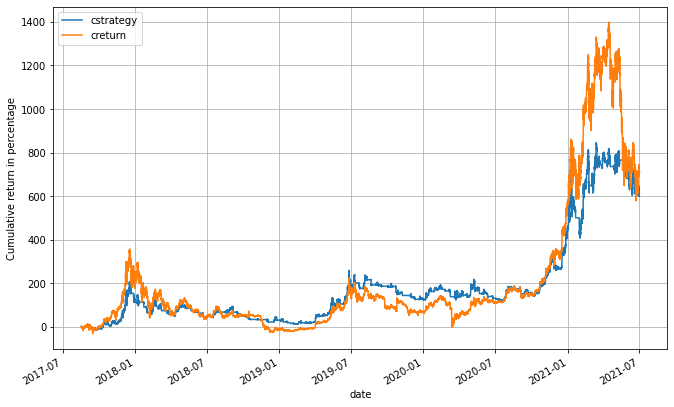

In [63]:
ds = GoldenCrossStrategy(trader_config, df)
ds.apply_strategy(200, 50, plot = True)

  0%|          | 0/46 [00:00<?, ?it/s]

Best result
     ma_high  ma_low   str_return  real_return
443      160      20  3190.925883   713.329837


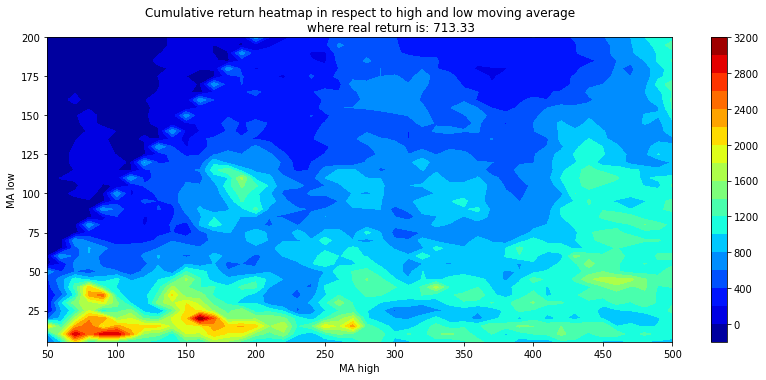

In [64]:
res = ds.optimize()

Strategy return: 31.909258832120855
Real return: 7.133298366377694


{'cum_real_ret': 7.133298366377694, 'cum_str_ret': 31.909258832120855}

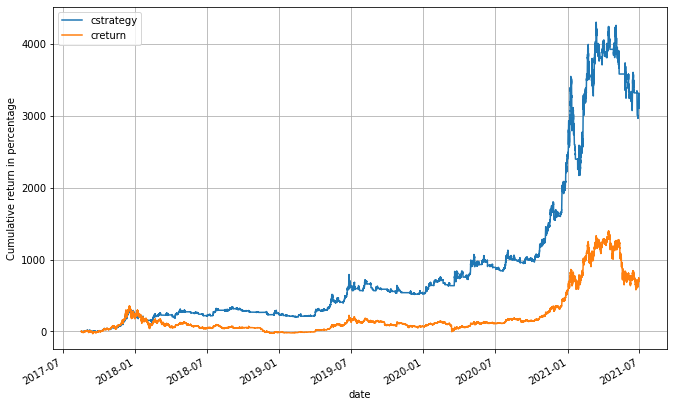

In [65]:
ds.apply_strategy(160, 20, plot = True)

Strategy return: 0.10700962818761295
Real return: 0.23155942359823478


{'cum_real_ret': 0.23155942359823478, 'cum_str_ret': 0.10700962818761295}

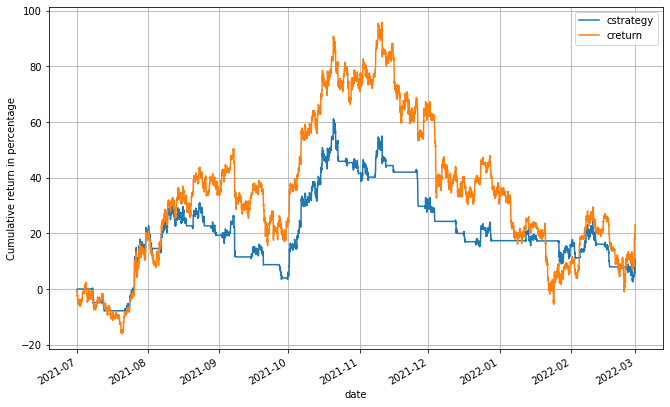

In [66]:
ds.apply_strategy(160, 20, plot = True, oos = True)